# 13. 텐서플로를 사용한 데이터 적재와 전처리

In [2]:
# 공통 모듈 임포트
import numpy as np
import os
import tensorflow as tf

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)    
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 13.1 데이터 API

In [4]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [10]:
X_nested = {'a': ([1, 2, 3], [4, 5, 6]), 'b': [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### 13.1.1 연쇄 변환

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [13]:
dataset = dataset.map(lambda x: x * 2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [14]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [15]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### 13.1.2 데이터 셔플링

In [19]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### 13.1.3 여러 파일에서 한 줄씩 번갈아 읽기

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [25]:
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [26]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [27]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [113]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length = n_readers
)

In [114]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.226,52.0,5.372469635627531,0.9473684210526315,1157.0,2.3421052631578947,37.96,-121.31,1.076', shape=(), dtype=string)
tf.Tensor(b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504', shape=(), dtype=string)
tf.Tensor(b'4.7361,7.0,7.464968152866242,1.1178343949044587,846.0,2.694267515923567,34.49,-117.27,1.745', shape=(), dtype=string)


### 13.1.4 데이터 전처리

In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [120]:
X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [121]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543047 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### 13.1.5 데이터 적재와 전처리 합치기

In [122]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None, n_parse_threads=5, shuffle_buffer_size = 10_000, seed=42, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length = n_readers, num_parallel_calls=n_read_threads
    )
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

### 13.1.6 프리페치

### 13.1.7 케라스와 데이터셋 사용하기

## 13.2 TFRecord 포맷

In [2]:
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b'This is the first record')
    f.write(b'And this is the second record')

In [3]:
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


2023-11-14 13:51:34.781745: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-14 13:51:34.781862: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-14 13:51:34.782257: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-14 13:51:34.782977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-14 13:51:34.783830: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 13.2.1 압축된 TFRecord 파일

In [4]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as f:
    f.write(b'Compress, compress, compress!')

In [5]:
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'], compression_type='GZIP')

### 13.2.2 프로토콜 버퍼 개요

In [20]:
%%writefile person.proto
syntax = 'proto3';
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Writing person.proto


In [21]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [22]:
%ls person*

person.desc    person.proto   person_pb2.py


In [30]:
from person_pb2 import Person
person = Person(name='Al', id=123, email=['a@b.com'])
print(person)

name: "Al"
id: 123
email: "a@b.com"



In [31]:
person.name

'Al'

In [32]:
person.name = 'Alice'
person.name

'Alice'

In [33]:
person.email[0]

'a@b.com'

In [34]:
person.email.append('c@d.com')
person.email

['a@b.com', 'c@d.com']

In [35]:
serialized = person.SerializeToString()
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [37]:
person2 = Person()
person2.ParseFromString(serialized)

27

In [39]:
person == person2

True

### 13.2.3 텐서플로 프로토콜 버퍼

In [42]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features = Features(
        feature={
            'name': Feature(bytes_list=BytesList(value=[b'Alice'])),
            'id': Feature(int64_list=Int64List(value=[123])),
            'emails': Feature(bytes_list=BytesList(value=[b'a@b.com', b'c@d.com']))
        }
    )
)

In [43]:
with tf.io.TFRecordWriter('my_contacts.tfrecord') as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

### 13.2.4 Example 프로토콜 버퍼 읽고 파싱하기 

In [46]:
feature_description = {
    'name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'emails': tf.io.VarLenFeature(tf.string)
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(['my_contacts.tfrecord']).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

In [47]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b'')

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [49]:
parsed_example['emails'].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [50]:
def parse(serialized_example):
    return tf.io.parse_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(['my_contacts.tfrecord']).batch(2).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Ten

### 13.2.5 SequenceExample 프로토콜 버퍼로 리스트의 리스트 다루기

In [52]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature = {
    'author_id': Feature(int64_list = Int64List(value=[123])),
    'title': Feature(bytes_list = BytesList(value = [b'A', b'desert', b'place', b'.'])),
    'pub_date': Feature(int64_list = Int64List(value = [1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list = BytesList(value=[word.encode('utf-8') for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context = context,
    feature_lists = FeatureLists(feature_list = {
        'content': FeatureList(feature = content_features),
        'comments': FeatureList(feature = comments_features)
    })
)

In [53]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [54]:
serialized_sequence_example = sequence_example.SerializeToString()
serialized_sequence_example

b"\nL\n\x12\n\tauthor_id\x12\x05\x1a\x03\n\x01{\n \n\x05title\x12\x17\n\x15\n\x01A\n\x06desert\n\x05place\n\x01.\n\x14\n\x08pub_date\x12\x08\x1a\x06\n\x04\xd7\x0c\x0c\x19\x12\xd0\x01\nj\n\x07content\x12_\n*\n(\n\x04When\n\x05shall\n\x02we\n\x05three\n\x04meet\n\x05again\n\x01?\n1\n/\n\x02In\n\x07thunder\n\x01,\n\tlightning\n\x01,\n\x02or\n\x02in\n\x04rain\n\x01?\nb\n\x08comments\x12V\n&\n$\n\x04When\n\x03the\n\nhurlyburly\n\x02's\n\x04done\n\x01.\n,\n*\n\x04When\n\x03the\n\x06battle\n\x02's\n\x04lost\n\x03and\n\x03won\n\x01."

In [55]:
context_feature_descriptions = {
    'author_id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'title': tf.io.VarLenFeature(tf.string),
    'pub_date': tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0])
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [56]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions, sequence_feature_descriptions
)

In [57]:
parsed_context

{'title': SparseTensor(indices=tf.Tensor(
 [[0]
  [1]
  [2]
  [3]], shape=(4, 1), dtype=int64), values=tf.Tensor([b'A' b'desert' b'place' b'.'], shape=(4,), dtype=string), dense_shape=tf.Tensor([4], shape=(1,), dtype=int64)),
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [58]:
parsed_context['title'].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [59]:
tf.RaggedTensor.from_sparse(parsed_feature_lists['content'])

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>

## 13.3 케라스의 전처리 층

### 13.3.1 Normalization 층

In [3]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss = 'mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)


2023-11-15 14:00:59.624789: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-15 14:00:59.624823: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-15 14:00:59.624837: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-15 14:00:59.625371: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-15 14:00:59.626298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-15 14:00:59.978533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
  1/363 [..............................] - ETA: 2:44 - loss: 7.9217

2023-11-15 14:01:01.477713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


363/363 [==============================] - 2s 5ms/step - loss: 2.6793 - val_loss: 0.8038
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 0.6527 - val_loss: 1.3866
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5723 - val_loss: 0.6264
Epoch 4/5
363/363 [==============================] - 2s 4ms/step - loss: 0.5588 - val_loss: 0.5102
Epoch 5/5
363/363 [==============================] - 2s 4ms/step - loss: 0.5521 - val_loss: 0.6031


In [4]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [5]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


2023-11-15 14:03:53.167167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


363/363 [==============================] - 2s 5ms/step - loss: 2.8450 - val_loss: 1.1329
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 0.7795 - val_loss: 0.8731
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.6555 - val_loss: 1.1817
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.6322 - val_loss: 0.8371
Epoch 5/5
363/363 [==============================] - 2s 5ms/step - loss: 0.6109 - val_loss: 0.9919


In [8]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]
y_pred = final_model(X_new)
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.9640682],
       [1.5896187],
       [2.5701478]], dtype=float32)>

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [10]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()
        return(inputs - self.mean_) / (self.std_ + eps)

In [11]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

### 13.3.2 Discretization 층

In [13]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [14]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

### 13.3.3 CategoryEncoding 층

In [20]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [23]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [24]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

### 13.3.4 StringLookup 층

In [26]:
cities = ['Auckland', 'Paris', 'Paris', 'San Francisco']
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([['Paris'], ['Auckland'], ['Auckland'], ['Montreal']])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

In [27]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode='one_hot')
str_lookup_layer.adapt(cities)
str_lookup_layer([['Paris'], ['Auckland'], ['Auckland'], ['Montreal']])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [29]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([['Paris'], ['Auckland'], ['Foo'], ['Bar'], ['Baz']])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

### 13.3.5 Hashing 층

In [30]:
hashing_layer = tf.keras.layers.Hashing(num_bins = 10)
hashing_layer([['Paris'], ['Tokyo'], ['Auckland'], ['Montreal']])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]])>

### 13.3.6 임베딩을 사용해 범부형 특성 인코딩하기

In [31]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.04719822,  0.04983213],
       [ 0.03705468, -0.015729  ],
       [-0.04719822,  0.04983213]], dtype=float32)>

In [32]:
tf.random.set_seed(42)
ocean_prox = ['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocab_size(), output_dim=2)
])

lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.01484182, -0.00484287],
       [ 0.0200063 , -0.02362906],
       [ 0.01484182, -0.00484287]], dtype=float32)>

In [37]:
num_input = tf.keras.layers.Input(shape=[8], name='num')
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name='cat')
cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])

### 13.3.7 텍스트 전처리

In [38]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

In [39]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode='tf_idf')
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

### 13.3.8 사전 훈련된 언어 모델 구성 요소 사용하기

In [40]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50/2')
sentence_embeddings = hub_layer(tf.constant(['To be', 'Not to be']))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

### 13.3.9 이미지 전처리 층

In [41]:
from sklearn.datasets import load_sample_images

images = load_sample_images()['images']
crop_image_layer = tf.keras.layers.CenterCrop(height = 100, width = 100)
cropped_images = crop_image_layer(images)

## 13.4 텐서플로 데이터셋 프로젝트

## 13.5 연습문제

### 9

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [31]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [33]:
from tensorflow.train import Example, Feature, Features, BytesList, Int64List

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features = Features(
            feature = {
                'image': Feature(bytes_list = BytesList(value = [image_data.numpy()])),
                'label': Feature(int64_list = Int64List(value = [label]))
            }
        )
    )

In [34]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [35]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [38]:
train_filepaths = write_tfrecords("./datasets/fashion_mnist/my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("./datasets/fashion_mnist/my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("./datasets/fashion_mnist/my_fashion_mnist.test", test_set)

2023-11-16 21:35:11.598865: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-16 21:35:24.464716: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-11-16 21:35:25.639523: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [41]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [42]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

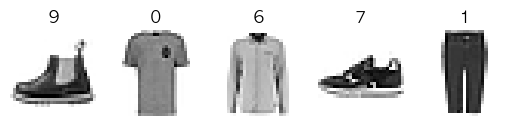

In [44]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap='binary')
        plt.axis('off')
        plt.title(str(y[i].numpy()))

In [45]:
tf.random.set_seed(42)
standardization = tf.keras.layers.Normalization(input_shape=[28, 28])
sample_image_batches = train_set.take(100).map(lambda image, lable: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

2023-11-16 21:45:30.994769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [47]:
from datetime import datetime
from pathlib import Path

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)
model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])


Epoch 1/5


2023-11-16 21:46:50.563539: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-16 21:46:50.563577: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-11-16 21:46:50.565422: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


     30/Unknown - 1s 11ms/step - loss: 1.4142 - accuracy: 0.5240

2023-11-16 21:46:51.799399: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-16 21:46:51.799412: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-11-16 21:46:51.809552: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-11-16 21:46:51.815297: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-11-16 21:46:51.818947: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run_/20231116_214650/plugins/profile/2023_11_16_21_46_51/ONEASH-MacBookAir.local.xplane.pb


   1719/Unknown - 16s 9ms/step - loss: 0.5759 - accuracy: 0.8074

2023-11-16 21:47:06.881085: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16965855212201369837
2023-11-16 21:47:06.881098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9186912594637338805
2023-11-16 21:47:06.881102: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15169961292704684925
2023-11-16 21:47:06.881363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3077956721981424094
2023-11-16 21:47:06.881371: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15822333100345431264
2023-11-16 21:47:06.881376: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12211016274603612608
2023-11-16 21:47:06.881381: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

1719/1719 [==============================] - 17s 9ms/step - loss: 0.5759 - accuracy: 0.8074 - val_loss: 0.5578 - val_accuracy: 0.8122
Epoch 2/5
   6/1719 [..............................] - ETA: 17s - loss: 0.4566 - accuracy: 0.8490

2023-11-16 21:47:07.723606: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17067754536311712732
2023-11-16 21:47:07.723620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4402620364284870993
2023-11-16 21:47:07.723623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6011712177030095339
2023-11-16 21:47:07.723627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12347049224484750268


1719/1719 [==============================] - 17s 10ms/step - loss: 0.5288 - accuracy: 0.8287 - val_loss: 0.5442 - val_accuracy: 0.8292
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.5417 - accuracy: 0.8289 - val_loss: 0.6093 - val_accuracy: 0.8256
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5608 - accuracy: 0.8282 - val_loss: 0.5907 - val_accuracy: 0.8258
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5814 - accuracy: 0.8258 - val_loss: 0.6564 - val_accuracy: 0.8188
